In [1]:
import datetime
import numpy as np
import pandas as pd
import random
import glob
from scipy.signal import find_peaks

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator
import matplotlib.backends.backend_pdf as p 


%matplotlib inline

import vasu

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

l=[]

In [2]:
def read_data(price_file):
    price_data = pd.read_csv(price_file,index_col=0, parse_dates = True,
                             usecols = [u'Date',u'Open Price', u'High Price', u'Low Price', u'Close Price'],
                             dtype= {u'Open Price':np.float64,u'High Price':np.float64,
                                     u'Low Price':np.float64,u'Close Price':np.float64}).sort_index()
    return price_data


Sell!
Benchmark Price is : 140.65
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 85.10


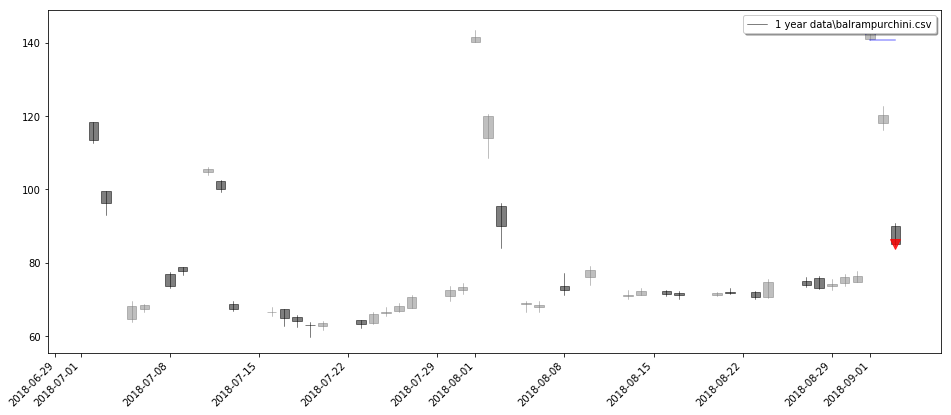

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 491.25
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 439.40


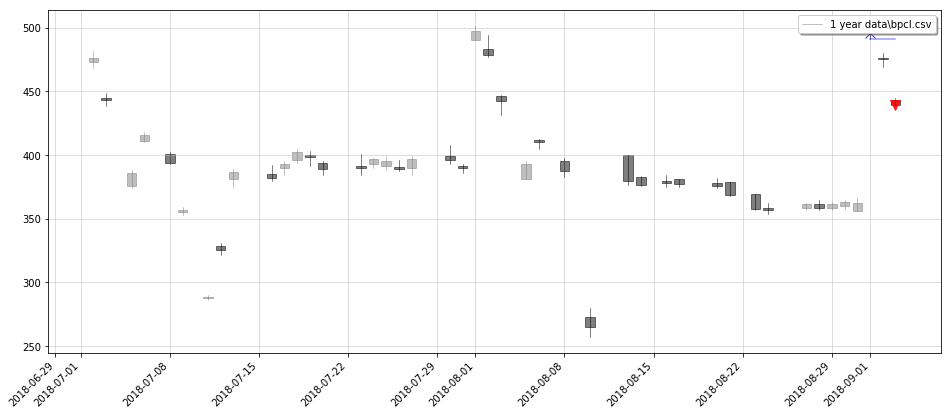

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 414.10
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 357.05


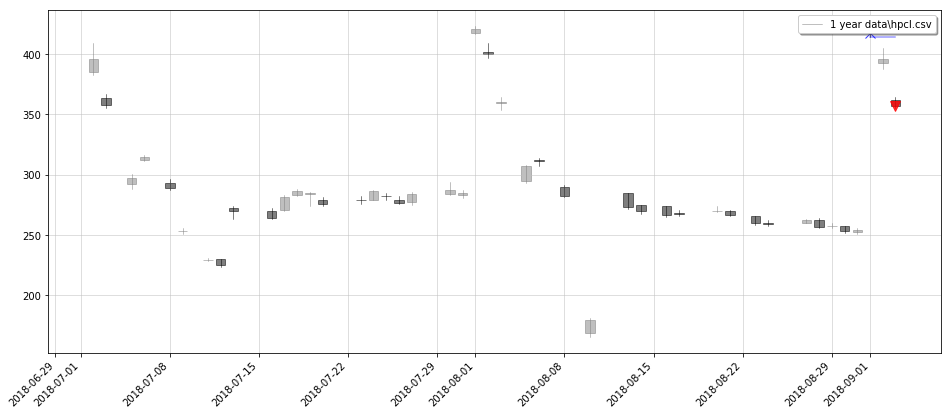

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 386.00
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 385.50


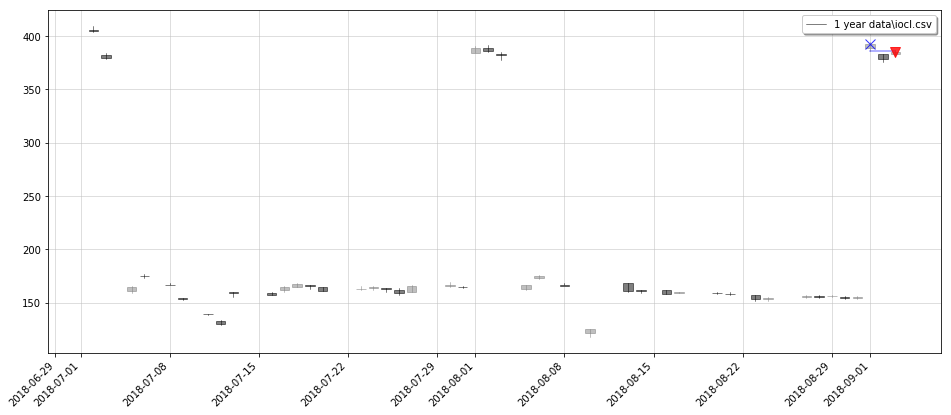

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 175.75
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 164.40


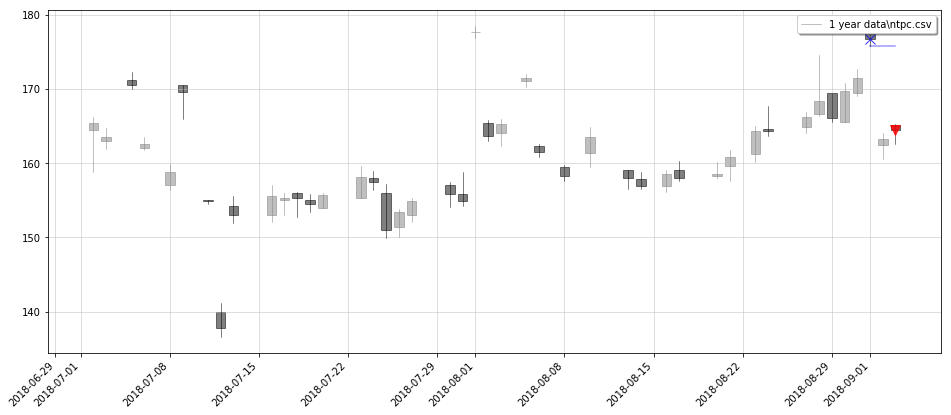

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 305.75
Signal Date is : 2018-09-02 00:00:00
Closing Price on signal is : 296.40


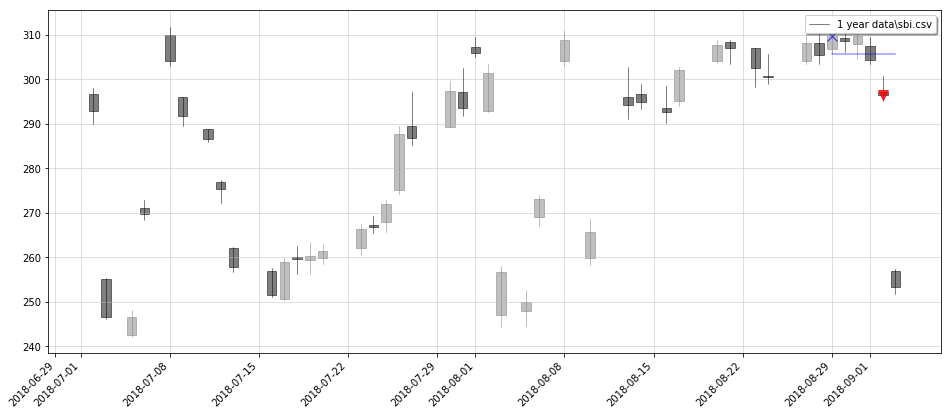

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 433.00
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 341.50


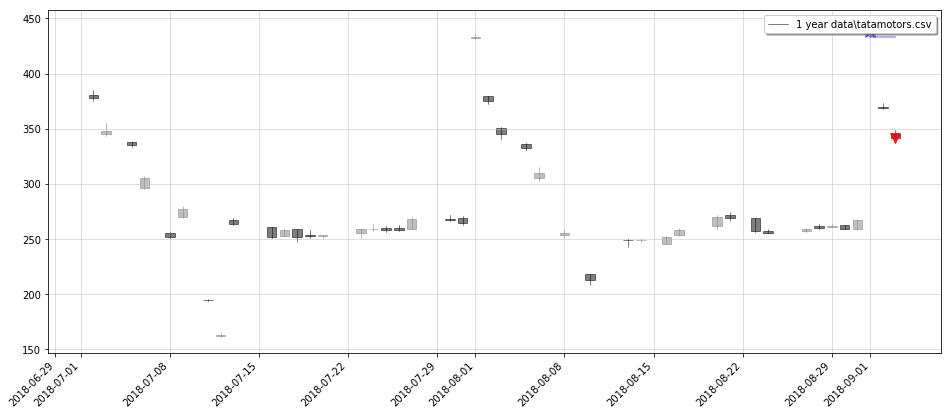

----------------------------------------------------------------------------
Sell!
Benchmark Price is : 767.00
Signal Date is : 2018-09-03 00:00:00
Closing Price on signal is : 606.75


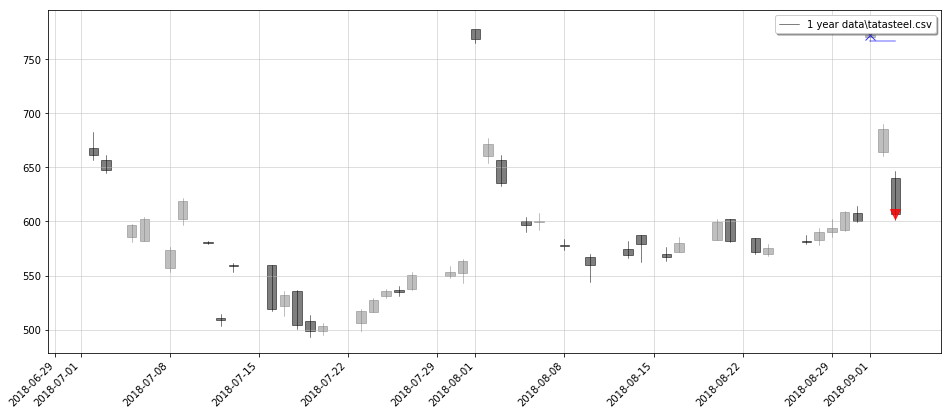

----------------------------------------------------------------------------
1 year data\balrampurchini.csv
1 year data\bpcl.csv
1 year data\hpcl.csv
1 year data\iocl.csv
1 year data\ntpc.csv
1 year data\sbi.csv
1 year data\tatamotors.csv
1 year data\tatasteel.csv


In [3]:
for file_name in glob.glob('1 year data/*.csv'):
    price_data = read_data(file_name)
    sample_data = price_data.loc[datetime.date(year=2018, month=7,day=2):datetime.date(year=2018,month=9,day=3)]
    #print(sample_data)
    trend_data = vasu.get_trend_data(sample_data)
    
    def split_data(dataframe):
        train_data = dataframe[(dataframe['high_slope'].notnull()) | (dataframe['low_slope'].notnull())].copy()
        test_data = dataframe[~((dataframe['high_slope'].notnull()) | (dataframe['low_slope'].notnull()))].copy()
        return train_data,test_data
    
    train_data,test_data = split_data(trend_data)
    
    def get_latest_peak_info(dataframe):
        return_dict = {}
        high_data = dataframe[dataframe['high_slope'].notnull()].tail(1)
        low_data = dataframe[dataframe['low_slope'].notnull()].tail(1)
        latest_high_date = high_data.index.to_pydatetime()[0]
        latest_low_date = low_data.index.to_pydatetime()[0]

        if latest_high_date > latest_low_date:
            return_dict['peak_type'] = 'high'
            return_dict['peak_data'] = high_data
        elif latest_high_date < latest_low_date:
            return_dict['peak_type'] = 'low'
            return_dict['peak_data'] = low_data
        else:
            return_dict['peak_type'] = 'high&low'
            return_dict['peak_data'] = low_data
    
        return return_dict
    
    peak_info =  get_latest_peak_info(train_data)
    peak_type = peak_info['peak_type']
    peak_data = peak_info['peak_data']
    
    peak_date = peak_data.index.to_pydatetime()[0]
    trend_before_peak = peak_data['trend'].values[0]
    peak_high_slope = peak_data['high_slope'].values[0]
    peak_low_slope = peak_data['low_slope'].values[0]
    peak_high = peak_data['High Price'].values[0]
    peak_low = peak_data['Low Price'].values[0]
 
    #higher high after bullish or sideways trend
    if (peak_type == 'high') and (peak_high_slope > 0.0) and (trend_before_peak != 'bearish'):
        low_mark_price = peak_low
        signal_data = test_data[test_data['Close Price'] < low_mark_price][1:2].copy()
        
        if len(signal_data) > 0:
            print('Sell!')
            print('Benchmark Price is : %.2f' % low_mark_price)
            print('Signal Date is : %s' % signal_data.index.to_pydatetime()[0])
            print('Closing Price on signal is : %.2f' % signal_data['Close Price'].values)
            l.append(file_name)  #the stocks which are beaarish
 

        signal_to_end_data = trend_data.loc[peak_date:].copy()
        signal_to_end_data['benchmark price'] = low_mark_price
        benchmark_series = signal_to_end_data['benchmark price']
    
    
        fig, ax = plt.subplots(figsize = (16,7))
        fig.subplots_adjust(bottom=0.2)

        quotes = zip(mdates.date2num(sample_data.index.to_pydatetime()),sample_data[u'Open Price'], 
                             sample_data[u'High Price'],sample_data[u'Low Price'], sample_data[u'Close Price'])
        candlestick_ohlc(ax,quotes,width=0.75,colorup='grey',colordown='black' ,alpha=0.5)

        plt.plot(benchmark_series, "-", color='blue', alpha = 0.4)
        plt.plot(signal_data['Close Price'], "v", color='red',markersize=10,alpha = 0.8)
        plt.plot(peak_data['Close Price'], "x", color='b',markersize=10, alpha = 0.8)

        ax.xaxis_date()
        ax.legend([file_name],loc='upper right', shadow=True, fancybox=True)
        ax.autoscale_view()
        plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

        plt.rc('axes', grid=True)
        plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
        plt.show()
        print('----------------------------------------------------------------------------')
for i in l:
    print(i)